# Particle Filters Usecass
______

In [1]:
import numpy as np
import dask.array as da
from sklearn.utils.validation import check_array, check_is_fitted

class BaseEstimator:
    """
    Base class for all estimators in the TFilterPy package.
    Provides common functionality such as parameter handling and validation.
    """

    def __init__(self, name=None):
        """
        Initialize the BaseEstimator.

        Args:
            name (str): Optional name for the estimator.
        """
        self.name = name or self.__class__.__name__

    @staticmethod
    def to_dask_array(numpy_array, chunk_size=None):
        """
        Convert a NumPy array to a Dask array with specified chunking.
        If chunk_size is None, use Dask's automatic chunking.
        
        Parameters:
            numpy_array (np.ndarray): Input array.
            chunk_size (int or tuple, optional): Desired chunk size.
            
        Returns:
            da.Array: Dask array version of numpy_array.
        """
        if chunk_size is None:
            return da.from_array(numpy_array, chunks="auto")
        else:
            if isinstance(chunk_size, int):
                chunks = tuple(chunk_size for _ in range(numpy_array.ndim))
            else:
                chunks = chunk_size
            return da.from_array(numpy_array, chunks=chunks)
    
    def get_params(self, deep=True):
        """
        Get parameters of the estimator.

        Args:
            deep (bool): If True, retrieves parameters of nested objects.

        Returns:
            dict: A dictionary of parameter names mapped to their values.
        """
        params = {}
        for key, value in self.__dict__.items():
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                params.update({f"{key}__{k}": v for k, v in deep_items})
            else:
                params[key] = value
        return params

    def set_params(self, **params):
        """
        Set parameters of the estimator.

        Args:
            **params: Arbitrary keyword arguments of parameters to set.

        Returns:
            self: Returns the instance itself.
        """
        for key, value in params.items():
            if not hasattr(self, key):
                raise ValueError(f"Invalid parameter: {key}")
            setattr(self, key, value)
        return self

    def validate_matrices(self, matrices):
        """
        Validate that matrices have consistent shapes and types.

        Args:
            matrices (dict): A dictionary of matrix names and their values.

        Raises:
            ValueError: If the matrices are inconsistent.
        """
        for name, matrix in matrices.items():
            if not isinstance(matrix, (np.ndarray, da.Array)):
                raise ValueError(f"{name} must be a NumPy or Dask array.")
            if matrix.ndim != 2:
                raise ValueError(f"{name} must be a 2D array.")
            if matrix.dtype != np.float64:
                raise ValueError(f"{name} must have dtype float64.")
        # Add shape consistency checks here if needed

    def _validate_data(self, X, y=None, reset=True, validate_separately=False, **check_array_params):
        """
        Validate input data using sklearn.utils.validation.check_array.
        """
        if y is None:
            X = check_array(X, reset=reset, validate_separately=validate_separately, **check_array_params)
            return X
        else:
            X, y = check_array(X, y, reset=reset, validate_separately=validate_separately, **check_array_params)
            return X, y

    def _check_is_fitted(self, attributes, msg=None, all_or_any=all):
        """
        Check if the estimator is fitted.
        """
        check_is_fitted(self, attributes, msg=msg, all_or_any=all_or_any)

    def __repr__(self):
        """
        String representation of the estimator.

        Returns:
            str: A string representation of the estimator.
        """
        return f"{self.name}({self.get_params(deep=False)})"

import dask
print(dask.__version__)

import dask.array as da
import numpy as np

class ParameterEstimator(BaseEstimator):
    r"""
    A class for estimating Kalman Filter parameters, such as process noise covariance (Q)
    and observation noise covariance (R), using different estimation methods.

    Estimation strategies include:
    - Residual Analysis
    - Maximum Likelihood Estimation (MLE)
    - Cross-Validation
    - Adaptive Filtering

    References:
    - Welch, G., & Bishop, G. (1995). An Introduction to the Kalman Filter.
    - Haykin, S. (2001). Kalman Filtering and Neural Networks.
    """

    def __init__(self, estimation_strategy: str = "residual_analysis"):
        r"""
        Initialize the ParameterEstimator with the desired estimation strategy.

        Parameters
        ----------
        estimation_strategy : str, optional
            The strategy to use for estimating parameters. Options include:
            - "residual_analysis": Estimate based on residuals after running the filter.
            - "mle": Maximum Likelihood Estimation (iterative approach).
            - "cross_validation": Perform k-fold cross-validation for best Q and R.
            - "adaptive_filtering": Dynamically update Q and R based on measurement residuals.

        Raises
        ------
        ValueError
            If an invalid estimation strategy is specified.
        """
        super().__init__(name="KalmanFilterParameterEstimator")
        valid_strategies = {
            "residual_analysis",
            "mle",
            "cross_validation",
            "adaptive_filtering",
        }
        if estimation_strategy not in valid_strategies:
            raise ValueError(
                f"Invalid strategy: {estimation_strategy}. Must be one of {valid_strategies}."
            )
        self.estimation_strategy = estimation_strategy

    def estimate_with_residual_analysis(self, measurements: da.Array) -> tuple:
        r"""
        Estimate process (Q) and observation (R) noise covariances using residual analysis.
        
        This method runs the Kalman filter on the provided measurements, computes the residuals,
        and estimates the noise covariances based on their statistical properties.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix.
        R : dask.array.Array
            Estimated observation noise covariance matrix.
        
        Notes
        -----
        - The process noise covariance (Q) is estimated as the covariance of the residuals.
        - The observation noise covariance (R) is approximated as a diagonal matrix scaled
          by the variance of the residuals.
        - Dask's auto-chunking is used to handle large datasets efficiently.
        """
        state_estimates, residuals = self.run_filter(measurements)
        Q = da.cov(residuals, rowvar=False)
        # Use auto chunking for the identity matrix
        R = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
        return Q, R

    def estimate_with_mle(self, measurements: da.Array, max_iterations: int = 5) -> tuple:
        r"""
        Estimate Q and R using Maximum Likelihood Estimation (MLE) through an iterative approach.
        
        This method iteratively refines the estimates of Q and R by running the Kalman filter
        and updating the covariances based on the residuals until convergence or the maximum
        number of iterations is reached.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        max_iterations : int, optional
            Maximum number of iterations for the MLE process. Default is 5.
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix.
        R : dask.array.Array
            Estimated observation noise covariance matrix.
        
        Notes
        -----
        - The method uses the variance of residuals to update Q and R in each iteration.
        - Intermediate results are persisted to avoid recomputation overhead in Dask.
        - Convergence is not explicitly checked; the loop runs for a fixed number of iterations.
        """
        Q, R = self.Q, self.R

        for _ in range(max_iterations):
            state_estimates, residuals = self.run_filter(measurements)
            # Use "auto" chunking for the identity matrices
            Q_new = da.eye(residuals.shape[1], chunks="auto") * da.var(residuals, axis=0)
            R_new = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            # Persist intermediate results to avoid recomputation overhead
            Q, R = Q_new.persist(), R_new.persist()

        return Q, R

    def estimate_with_cross_validation(self, measurements: da.Array, k_folds: int = 5) -> tuple:
        r"""
        Estimate Q and R using k-fold cross-validation to find the best noise covariance parameters.
        
        This method splits the data into k folds, trains the Kalman filter on k-1 folds, and
        validates on the remaining fold. The Q and R pair with the lowest validation error is selected.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        k_folds : int, optional
            Number of folds for cross-validation. Default is 5.
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix from the best fold.
        R : dask.array.Array
            Estimated observation noise covariance matrix from the best fold.
        
        Notes
        -----
        - The validation score is the mean squared error between predicted and actual measurements.
        - All folds are computed lazily using Dask and finalized with `da.compute`.
        - The method assumes the data can be evenly divided into folds; edge cases may need adjustment.
        """
        n_samples = measurements.shape[0]
        fold_size = n_samples // k_folds

        fold_scores, fold_Qs, fold_Rs = [], [], []

        for fold in range(k_folds):
            val_start = fold * fold_size
            val_end = val_start + fold_size
            train_data = da.concatenate([measurements[:val_start], measurements[val_end:]])
            val_data = measurements[val_start:val_end]

            state_estimates, residuals = self.run_filter(train_data)
            val_score = da.mean((val_data - state_estimates[:fold_size]) ** 2)
            fold_scores.append(val_score)

            Q_fold = da.cov(residuals.T)
            R_fold = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            fold_Qs.append(Q_fold)
            fold_Rs.append(R_fold)

        # Compute all folds lazily and choose the best fold
        fold_scores, fold_Qs, fold_Rs = da.compute(fold_scores, fold_Qs, fold_Rs)
        best_fold = np.argmin(fold_scores)
        return fold_Qs[best_fold], fold_Rs[best_fold]

    def estimate_with_adaptive_filtering(self, measurements: da.Array, alpha: float = 0.01) -> tuple:
        r"""
        Estimate Q and R adaptively based on innovations over time using a smoothing approach.
        
        This method dynamically updates the noise covariances by incorporating new information
        from the innovations (measurement residuals) with a small learning rate.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        alpha : float, optional
            Number of folds for cross-validation. Default is 5.
        
        
        Returns
        -------
        Q : dask.array.Array
            Estimated process noise covariance matrix.
        R : dask.array.Array
            Estimated observation noise covariance matrix.
        
        Notes
        -----
        - Innovations are calculated as the difference between measurements and predicted observations.
        - The update uses an exponential moving average with a fixed alpha (learning rate) of 0.01.
        - Dask's `einsum` is used for efficient outer product computation of innovations.
        """
        Q, R = self.Q, self.R
        # alpha = 0.01
        innovations = measurements - da.dot(self.H, self.x)
        outer_products = da.einsum("ij,ik->ijk", innovations, innovations)
        Q_new = da.mean(outer_products, axis=0).rechunk("auto")
        R_new = da.var(innovations, axis=0).rechunk("auto")

        Q = (1 - alpha) * Q + alpha * Q_new
        R = (1 - alpha) * R + alpha * R_new
        return Q, R

    def estimate_parameters(self, measurements: da.Array):
        r"""
        Estimate the parameters Q and R using the specified estimation strategy.
        
        This method serves as a dispatcher, calling the appropriate estimation method based
        on the initialized `estimation_strategy`.
        
        Parameters
        ----------
        measurements : dask.array.Array
            Array of shape (n_samples, n_observations) containing the measurement data.
        
        Returns
        -------
        tuple
            A tuple (Q, R) containing the estimated process and observation noise covariance matrices.
        """
        return getattr(self, f"estimate_with_{self.estimation_strategy}")(measurements)


import numpy as np
import dask.array as da
# from tfilterspy.utils.optimisation_utils import ParameterEstimator



class DaskParticleFilter(ParameterEstimator):
    r"""
    A multivariate, scalable particle filter using Dask. Inherits parameter estimation 
    methods from ParameterEstimator.
    
    This implementation provides a flexible particle filter that can operate with either NumPy 
    or Dask arrays, making it suitable for both small-scale and large-scale state estimation 
    problems. It follows the standard sequential importance resampling (SIR) framework.
    
    References
    ----------
    - Gordon,.ConcurrentN. J., Salmond, D. J., & Smith, A. F. M. (1993). Novel approach to nonlinear/non-Gaussian 
        Bayesian state estimation. IEE Proceedings F - Radar and Signal Processing, 140(2), 107-113.
    - Doucet, A., & Johansen, A. M. (2009). A tutorial on particle filtering and smoothing: 
        Fifteen years later. Handbook of Nonlinear Filtering, 12(656-704).
    """
    def __init__(self, state_transition, observation_model, process_noise_cov, 
                 observation_noise_cov, initial_state, num_particles=1000, use_dask=True, 
                 estimation_strategy="residual_analysis"):
        r"""
        Initialize the DaskParticleFilter with filter parameters and estimation strategy.
        
        Parameters
        ----------
        state_transition : array-like
            State transition matrix of shape (state_dim, state_dim) defining the linear 
            dynamics of the system.
        observation_model : array-like
            Observation matrix of shape (obs_dim, state_dim) mapping states to observations.
        process_noise_cov : array-like
            Process noise covariance matrix of shape (state_dim, state_dim).
        observation_noise_cov : array-like
            Observation noise covariance matrix of shape (obs_dim, obs_dim).
        initial_state : array-like
            Initial state vector of shape (state_dim,).
        num_particles : int, optional
            Number of particles to use in the filter. Default is 1000.
        use_dask : bool, optional
            If True, use Dask arrays for scalable computation; otherwise, use NumPy arrays. 
            Default is True.
        estimation_strategy : str, optional
            Strategy for estimating Q and R, inherited from ParameterEstimator. Options include 
            "residual_analysis", "mle", "cross_validation", "adaptive_filtering". Default is 
            "residual_analysis".
        
        Notes
        -----
        - The filter assumes a linear state transition and observation model. For nonlinear 
          models, consider extending with callable functions (see Doucet & Johansen, 2009).
        - When `use_dask` is True, inputs are converted to Dask arrays with chunking for 
          scalability.
        """
        # Initialize the ParameterEstimator
        super().__init__(estimation_strategy=estimation_strategy)
        self.use_dask = use_dask
        self.state_dim = initial_state.shape[0]
        self.num_particles = num_particles

        # Convert inputs to Dask arrays if scalability is desired
        if self.use_dask:
            self.state_transition = da.from_array(state_transition, chunks=state_transition.shape)
            self.observation_model = da.from_array(observation_model, chunks=observation_model.shape)
            self.process_noise_cov = da.from_array(process_noise_cov, chunks=process_noise_cov.shape)
            self.observation_noise_cov = da.from_array(observation_noise_cov, chunks=observation_noise_cov.shape)
            self.initial_state = da.from_array(initial_state, chunks=initial_state.shape)
        else:
            self.state_transition = state_transition
            self.observation_model = observation_model
            self.process_noise_cov = process_noise_cov
            self.observation_noise_cov = observation_noise_cov
            self.initial_state = initial_state

        # Step 1: Initialization - all particles start at the same known state
        particles_np = np.repeat(initial_state.reshape(1, self.state_dim), num_particles, axis=0)
        if self.use_dask:
            self.particles = da.from_array(particles_np, chunks=(num_particles // 10, self.state_dim))
        else:
            self.particles = particles_np
        
        # Uniform weights
        weights_np = np.ones(num_particles) / num_particles
        if self.use_dask:
            self.weights = da.from_array(weights_np, chunks=(num_particles // 10,))
        else:
            self.weights = weights_np

        # Current state estimate (initially set to the initial state)
        self.state = self.initial_state.compute() if self.use_dask else self.initial_state

        # For parameter estimation methods, we store a copy of Q and R (could be updated later)
        # For demonstration, we initialize them as given.
        self.Q = self.process_noise_cov
        self.R = self.observation_noise_cov

    def predict(self):
        r"""
            Propagate each particle forward using the state transition model and Gaussian process noise.
            
            This step implements the prediction phase of the particle filter, where particles are 
            evolved according to the system dynamics plus random noise.
            
            Notes
            -----
            - Noise is sampled from a multivariate normal distribution with covariance `Q`.
            - For Dask, particles are persisted to optimize memory usage in distributed settings.
            - See Gordon et al. (1993) for the foundational SIR algorithm's prediction step.
            
            References
            ----------
            - Gordon, N. J., Salmond, D. J., & Smith, A. F. M. (1993). Novel approach to nonlinear/non-Gaussian 
              Bayesian state estimation. IEE Proceedings F - Radar and Signal Processing, 140(2), 107-113.
        """
        noise_np = np.random.multivariate_normal(
            np.zeros(self.state_dim),
            self.process_noise_cov.compute() if self.use_dask else self.process_noise_cov,
            self.num_particles
        )
        if self.use_dask:
            noise = da.from_array(noise_np, chunks=self.particles.chunksize)
        else:
            noise = noise_np
        
        if self.use_dask:
            self.particles = da.dot(self.particles, self.state_transition.T) + noise
            self.particles = self.particles.persist()
        else:
            self.particles = (self.state_transition @ self.particles.T).T + noise

    def update(self, measurement):
        r"""
            Update particle weights based on the likelihood of the observed measurement.
            
            This step computes the likelihood of each particle given the measurement and updates 
            their weights accordingly, followed by resampling and state estimation.
            
            Parameters
            ----------
            measurement : array-like
                Observed measurement vector of shape (obs_dim,).
            
            Notes
            -----
            - Assumes a scalar observation noise variance (R[0, 0]) for simplicity. For multivariate 
              observations, extend to use the full covariance matrix (Doucet & Johansen, 2009).
            - Adds a small constant (1e-300) to weights to prevent degeneracy.
            - Triggers resampling to mitigate particle impoverishment.
            
            References
            ----------
            - Doucet, A., & Johansen, A. M. (2009). A tutorial on particle filtering and smoothing: 
              Fifteen years later. Handbook of Nonlinear Filtering, 12(656-704).
        """
        if self.use_dask and not isinstance(measurement, da.Array):
            measurement = da.from_array(measurement, chunks=measurement.shape)
        
        if self.use_dask:
            predicted_measurements = da.dot(self.particles, self.observation_model.T)
        else:
            predicted_measurements = (self.observation_model @ self.particles.T).T
        
        diff = predicted_measurements - measurement
        
        R_val = self.observation_noise_cov[0, 0].compute() if self.use_dask else self.observation_noise_cov[0, 0]
        if self.use_dask:
            likelihood = da.exp(-0.5 * da.sum(diff**2, axis=1) / R_val)
        else:
            likelihood = np.exp(-0.5 * np.sum(diff**2, axis=1) / R_val)
        
        self.weights = self.weights * likelihood
        self.weights = self.weights + 1e-300  # Avoid zero weights
        self.weights = self.weights / self.weights.sum()
        
        self.resample()
        self.estimate_state()

    def resample(self):
        r"""
            Resample particles to refocus on high-probability regions using multinomial resampling.
            
            This step addresses particle degeneracy by resampling particles proportional to their 
            weights, then resetting weights to uniform values.
            
            Notes
            -----
            - Uses multinomial resampling, which is simple but can be less efficient than systematic 
              resampling (Gordon et al., 1993).
            - For Dask, requires computing weights and particles, which may limit scalability; 
              consider stratified or systematic resampling for large-scale applications.
            
            References
            ----------
            - Gordon, N. J., Salmond, D. J., & Smith, A. F. M. (1993). Novel approach to nonlinear/non-Gaussian 
              Bayesian state estimation. IEE Proceedings F - Radar and Signal Processing, 140(2), 107-113.
        """
        weights_np = self.weights.compute() if self.use_dask else self.weights
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=weights_np)
        if self.use_dask:
            particles_np = self.particles.compute()
            particles_resampled = particles_np[indices]
            self.particles = da.from_array(particles_resampled, chunks=self.particles.chunksize)
            self.weights = da.from_array(np.ones(self.num_particles) / self.num_particles, chunks=self.weights.chunksize)
        else:
            self.particles = self.particles[indices]
            self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate_state(self):
        r"""
            Compute the state estimate as the weighted average of particles.
            
            This step provides the final state estimate after updating and resampling, representing 
            the expected state given the current particle distribution.
            
            Notes
            -----
            - For Dask, the estimate is computed immediately to provide a concrete result; for lazy 
              evaluation, consider returning a Dask array instead.
            - The weighted average is a common estimator in particle filtering (Doucet & Johansen, 2009).
            
            References
            ----------
            - Doucet, A., & Johansen, A. M. (2009). A tutorial on particle filtering and smoothing: 
              Fifteen years later. Handbook of Nonlinear Filtering, 12(656-704).
        """
        if self.use_dask:
            self.state = da.average(self.particles, weights=self.weights, axis=0).compute()
        else:
            self.state = np.average(self.particles, weights=self.weights, axis=0)

    def step(self, measurement):
        r"""
            Run one full filter cycle: predict, update, resample, and state estimation.
            
            This method encapsulates a single iteration of the particle filter, processing one 
            measurement and returning the updated state estimate.
            
            Parameters
            ----------
            measurement : array-like
                Observed measurement vector of shape (obs_dim,).
            
            Returns
            -------
            state : ndarray
                Estimated state vector of shape (state_dim,).
            
            Notes
            -----
            - Combines the prediction and update steps as per the SIR framework (Gordon et al., 1993).
        """
        self.predict()
        self.update(measurement)
        return self.state

    def run_filter(self, measurements):
        r"""
            Run the particle filter over a sequence of measurements and return state estimates and residuals.
            
            This method is required for parameter estimation routines inherited from ParameterEstimator. 
            It processes a time series of measurements sequentially and computes residuals for parameter tuning.
            
            Parameters
            ----------
            measurements : array-like
                Array of measurements over time, shape (n_timesteps, obs_dim).
            
            Returns
            -------
            state_estimates : da.Array or ndarray
                Filtered state estimates, shape (n_timesteps, state_dim).
            residuals : da.Array or ndarray
                Residuals (measurement - predicted_measurement), shape (n_timesteps, obs_dim).
            
            Notes
            -----
            - For simplicity, this implementation runs sequentially; for scalability, consider vectorizing 
              with Dask operations (Doucet & Johansen, 2009).
            - Residuals are computed as the difference between actual and predicted measurements, useful 
              for covariance estimation.
        """
        n_timesteps = measurements.shape[0]
        state_estimates = []
        residuals = []
        for i in range(n_timesteps):
            meas = measurements[i]
            # Predict and update for current measurement
            self.step(meas)
            state_estimates.append(self.state)
            # Compute predicted measurement from the current state estimate
            if self.use_dask:
                pred_meas = da.dot(da.from_array(self.state, chunks=self.state.shape), self.observation_model.T).compute()
            else:
                pred_meas = self.observation_model @ self.state
            # Residual is difference between actual measurement and predicted measurement
            res = (meas.compute() if self.use_dask else meas) - pred_meas
            residuals.append(res)
        # Convert lists to dask arrays (or numpy arrays)
        state_estimates = da.from_array(np.vstack(state_estimates)) if self.use_dask else np.vstack(state_estimates)
        residuals = da.from_array(np.vstack(residuals)) if self.use_dask else np.vstack(residuals)
        return state_estimates, residuals


2024.8.0


Train MSE: 31.6773
Test MSE: 34.3587


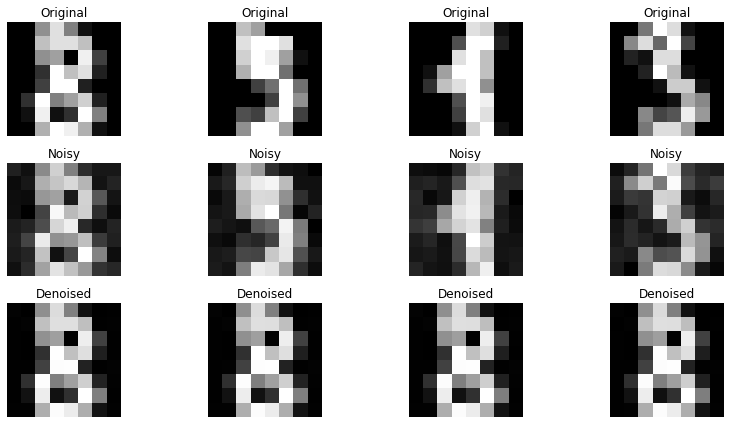

Classification Accuracy: 0.0000


In [2]:
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from  tfilterspy.state_estimation.linear_filters import DaskKalmanFilter
from  tfilterspy.state_estimation.particle_filters import DaskParticleFilter

# Load and split the digits dataset (20 samples)
digits = load_digits()
x = digits.data[0:20]  # Shape: (20, 64)
y = digits.target[0:20]  # Shape: (20,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(10, 64))  # 16 samples
x_test_dask = da.from_array(x_test, chunks=(10, 64))    # 4 samples
y_train_dask = da.from_array(y_train, chunks=(10,))
y_test_dask = da.from_array(y_test, chunks=(10,))

# Add synthetic noise
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)
noisy_x_test_dask = x_test_dask + da.random.normal(0, noise_level, x_test_dask.shape, chunks=x_test_dask.chunks)

# Particle Filter Setup
n_features = 64  # 8x8 pixels
F = np.eye(n_features)  # Static transition
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = x_train[0]     # First clean image as initial guess

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# Denoise Training and Test Sets
train_states, _ = pf.run_filter(noisy_x_train_dask)
denoised_x_train = train_states.compute()  # Shape: (16, 64)

# Reinitialize for test set (optional: could reuse same filter state)
pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=x_test[0],  # First test image
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)
test_states, _ = pf.run_filter(noisy_x_test_dask)
denoised_x_test = test_states.compute()  # Shape: (4, 64)

# Evaluate Denoising
mse_train = np.mean((x_train - denoised_x_train) ** 2)
mse_test = np.mean((x_test - denoised_x_test) ** 2)
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

# Visualize (first 4 training images)
n_display = 4
plt.figure(figsize=(12, 6))
for i in range(n_display):
    # Original
    plt.subplot(3, n_display, i + 1)
    plt.imshow(x_train[i].reshape(8, 8), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    # Noisy
    plt.subplot(3, n_display, i + 1 + n_display)
    plt.imshow(noisy_x_train_dask[i].compute().reshape(8, 8), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    # Denoised
    plt.subplot(3, n_display, i + 1 + 2 * n_display)
    plt.imshow(denoised_x_train[i].reshape(8, 8), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Optional: Classification
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(denoised_x_train, y_train)
y_pred = clf.predict(denoised_x_test)
accuracy = np.mean(y_pred == y_test)
print(f"Classification Accuracy: {accuracy:.4f}")

# Multi-variate Time Series

Data shape: (20, 14)
Mean Squared Error: 220752.7683


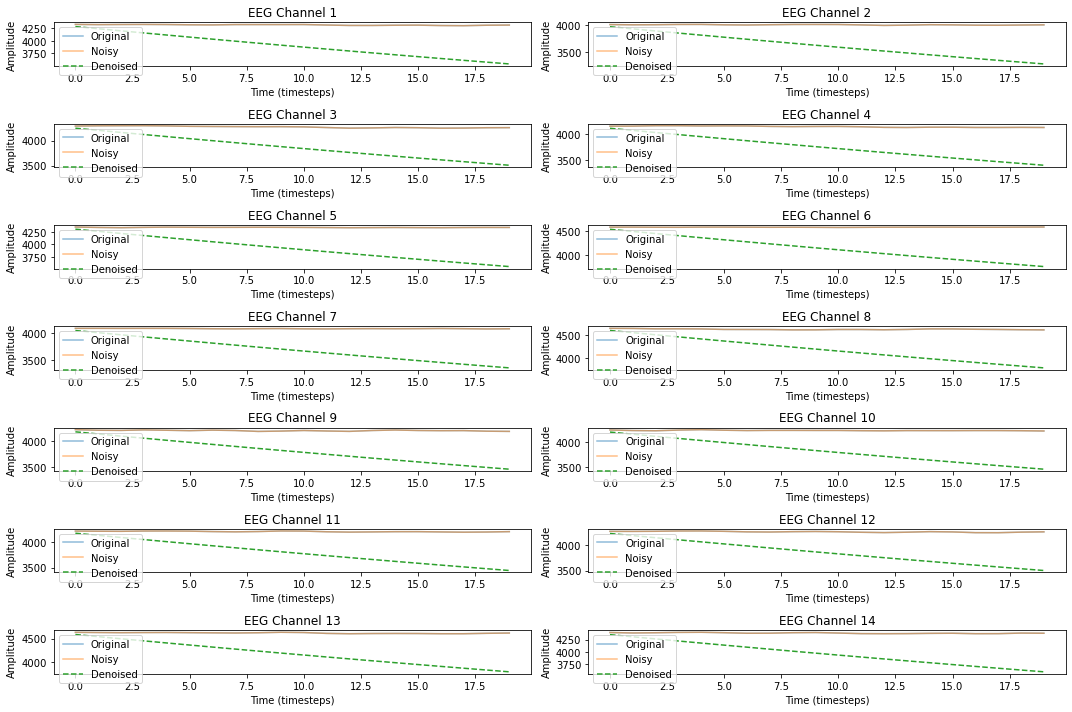

In [3]:
from sklearn.datasets import fetch_openml
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
# from your_module import DaskParticleFilter  # Adjust import

# 1. Load EEG Eye State data
data = fetch_openml(name='eeg-eye-state', version=1, as_frame=False)
X = data.data[0:20]  # Shape: (14980, 14)
X_dask = da.from_array(X, chunks=(1000, 14))
print(f"Data shape: {X_dask.shape}")

# 2. Add Synthetic Noise
noise_level = 0.5  # Adjust noise intensity
noisy_X_dask = X_dask + da.random.normal(0, noise_level, X_dask.shape, chunks=X_dask.chunks)

# 3. Particle Filter Setup
n_features = 14  # 14 EEG channels
F = np.eye(n_features) * 0.99  # Slow drift (near-static transition)
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = X[0]           # First timestep as initial state

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# 4. Run Filter to Denoise
state_estimates, residuals = pf.run_filter(noisy_X_dask)
denoised_X = state_estimates.compute()  # Shape: (14980, 14)

# 5. Evaluate
mse = np.mean((X - denoised_X) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

# 6. Visualize (first 1000 timesteps, all channels)
subset_size = 1000
X_subset = X[:subset_size]
noisy_subset = noisy_X_dask[:subset_size].compute()
denoised_subset = denoised_X[:subset_size]

plt.figure(figsize=(15, 10))
for i in range(14):
    plt.subplot(7, 2, i + 1)
    plt.plot(X_subset[:, i], label="Original", alpha=0.5)
    plt.plot(noisy_subset[:, i], label="Noisy", alpha=0.5)
    plt.plot(denoised_subset[:, i], label="Denoised", linestyle="--")
    plt.title(f"EEG Channel {i+1}")
    plt.xlabel("Time (timesteps)")
    plt.ylabel("Amplitude")
    plt.legend()
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np
import dask.array as da
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
# from your_module import DaskParticleFilter  # Adjust import

# 1. Load Disaster Tweets
data_path = r'C:\Users\thabanglukhetho\Documents\gits\tfilterPy\examples\data\train_nlp.csv'
df = pd.read_csv(data_path)
tweets = df['text'].values[0:5000]  # 500 tweets for testing
print(f"Number of tweets: {len(tweets)}")

# 2. Preprocess and Extract Topics
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(tweets)
n_topics = 5  # e.g., disaster, weather, casual, news, other
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topic_dist = lda.fit_transform(X)  # Shape: (500, 5)
X_dask = da.from_array(topic_dist, chunks=(100, n_topics))  # Adjusted chunks for 500 samples
print(f"Topic distribution shape: {X_dask.shape}")

# 3. Particle Filter Setup
F = np.eye(n_topics) * 0.95  # Slight decay for smooth topic evolution
H = np.eye(n_topics)  # Direct observation
Q = np.eye(n_topics) * 0.01  # Process noise
R = np.eye(n_topics) * 0.1   # Observation noise
initial_state = topic_dist[0]  # First tweet’s topics

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# 4. Run Filter to Track Topics
state_estimates, residuals = pf.run_filter(X_dask)
smoothed_topics = state_estimates.compute()  # Shape: (500, 5)

# 5. Plot Raw vs Smoothed Topics (first 500 tweets)
subset_size = 500  # Full set since we’re using 500 tweets
plt.figure(figsize=(12, 8))
for i in range(n_topics):
    plt.subplot(n_topics, 1, i + 1)
    plt.plot(topic_dist[:subset_size, i], label=f"Raw Topic {i+1}", alpha=0.5)
    plt.plot(smoothed_topics[:subset_size, i], label=f"Filtered Topic {i+1}", linestyle="--")
    plt.title(f"Topic {i+1}")
    plt.xlabel("Tweet Index (Time)")
    plt.ylabel("Probability")
    plt.legend()
plt.tight_layout()
plt.show()

# 6. Interpret Topics
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [feature_names[j] for j in topic.argsort()[-5:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

# 7. Optional: Check Final State and Parameters
print("Final estimated state:", pf.state)
Q_est, R_est = pf.estimate_parameters(X_dask)
print("Estimated Q:", Q_est.compute())
print("Estimated R:", R_est.compute())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\thabanglukhetho\\Documents\\gits\\tfilterPy\\examples\\data\\train_nlp.csv'